In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer

In [2]:
df=pd.read_csv('../data/insurance_data.csv')

C:\Users\hp\AppData\Local\Temp\ipykernel_17000\203990349.py:1: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../data/insurance_data.csv')


In [3]:
# Drop columns directly in the original DataFrame

columns_to_drop = ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Country', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType']
df = df.drop(columns=columns_to_drop)


In [4]:
print(df.columns)

Index(['Gender', 'Province', 'PostalCode', 'TotalPremium', 'TotalClaims'], dtype='object')


In [5]:
# Add derived features
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
df['Claim_to_Premium_Ratio'] = df['TotalClaims'] / (df['TotalPremium'] + 1)  # Avoid division by zero
df['Log_Premium'] = np.log1p(df['TotalPremium'])
df['Log_Total_Claim'] = np.log1p(df['TotalClaims'])

c:\Users\hp\anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\hp\anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Encode categorical features
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})  # Encode Gender
df = pd.get_dummies(df, columns=['Province', 'PostalCode'], drop_first=True)  # One-hot encode categorical variables

In [7]:
# Define features and target
X = df.drop(['TotalClaims'], axis=1)
y = df['TotalClaims']

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train a baseline Random Forest model
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# Evaluate the baseline model
baseline_pred = baseline_model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 412.4733970958907


In [11]:
# Visualize a single tree with limited depth
def visualize_tree(forest_model, feature_names, tree_index=0, max_depth=4):
    """
    Visualize a single tree with a limited depth from the Random Forest model.

    Args:
    - forest_model: The trained Random Forest model.
    - feature_names: List of feature names.
    - tree_index: Index of the tree to visualize.
    - max_depth: Maximum depth of the tree to display.
    """
    tree = forest_model.estimators_[tree_index]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, max_depth=max_depth, filled=True, rounded=True, fontsize=10)
    plt.title(f"Tree {tree_index} from the Random Forest (Max Depth: {max_depth})")
    plt.show()

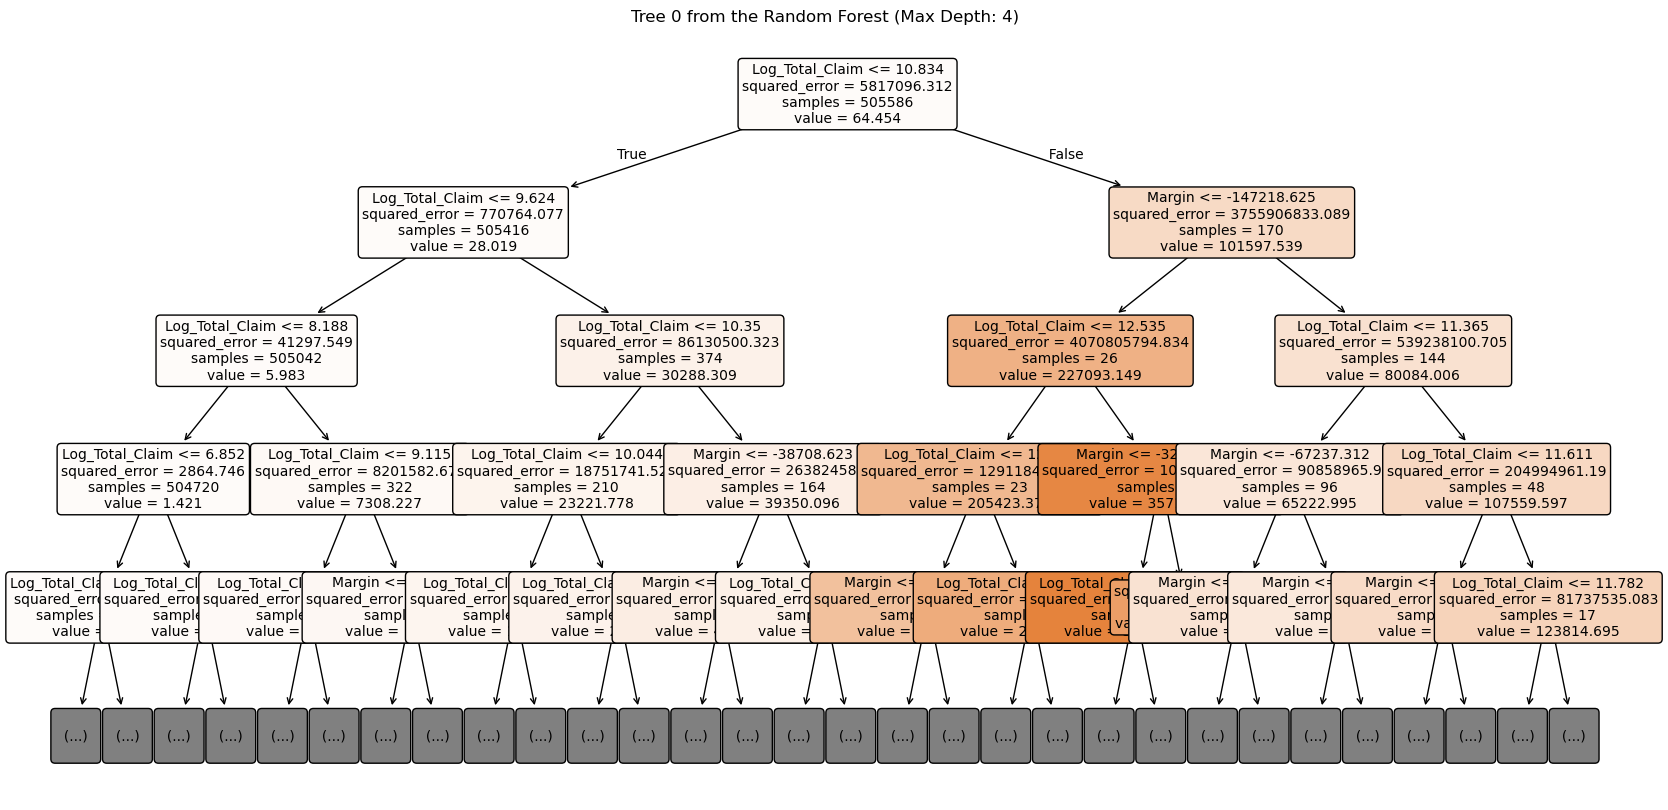

In [12]:
# Example: Visualize the first tree (tree index = 0)
visualize_tree(baseline_model, X.columns.tolist(), tree_index=0, max_depth=4)

In [13]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(baseline_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [14]:
shap_values

array([[ 2.24740558e-07,  2.93065766e-02, -8.19872770e+00, ...,
         0.00000000e+00,  2.51455262e-07,  0.00000000e+00],
       [ 3.49304425e-07,  2.93049382e-02, -8.19853986e+00, ...,
         0.00000000e+00,  2.51455262e-07,  0.00000000e+00],
       [ 2.24740558e-07,  2.93008533e-02, -8.19878225e+00, ...,
         0.00000000e+00,  2.51455262e-07,  0.00000000e+00],
       ...,
       [-2.43634776e-07,  2.94107632e-02, -8.20004925e+00, ...,
         0.00000000e+00,  2.51455262e-07,  0.00000000e+00],
       [ 2.57715236e-07,  2.93557045e-02, -8.19953252e+00, ...,
         0.00000000e+00,  2.51455262e-07,  0.00000000e+00],
       [ 3.49304425e-07,  2.93550684e-02, -8.19862497e+00, ...,
         0.00000000e+00,  2.51455262e-07,  0.00000000e+00]])

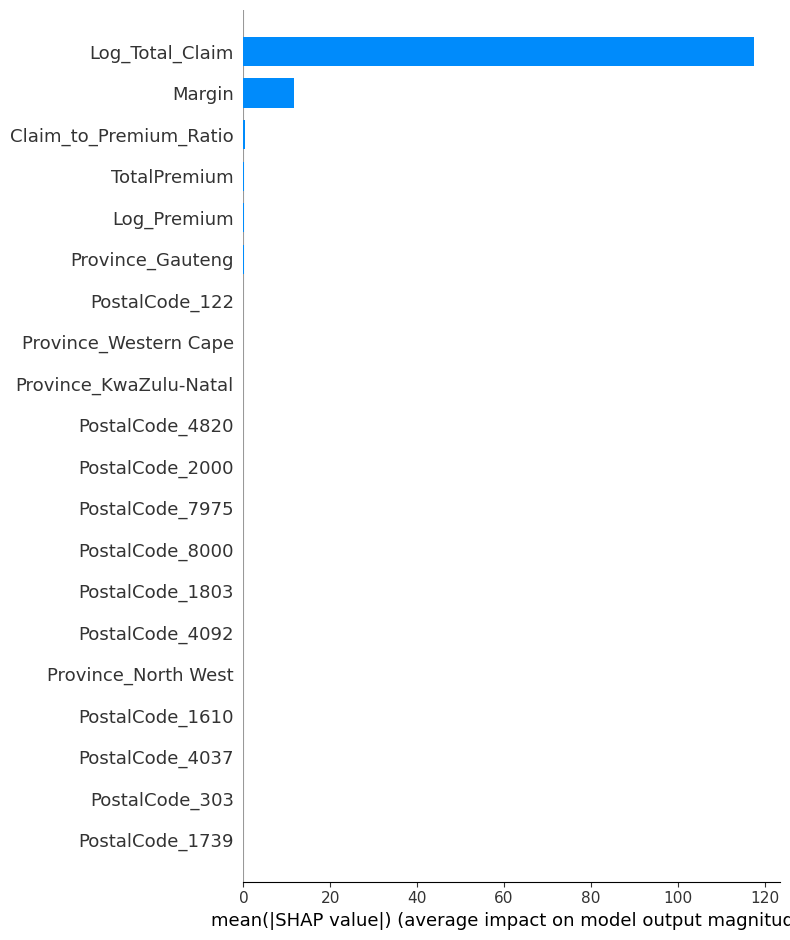

In [15]:
# Visualize feature importance globally
shap.summary_plot(shap_values, X_test, plot_type="bar")

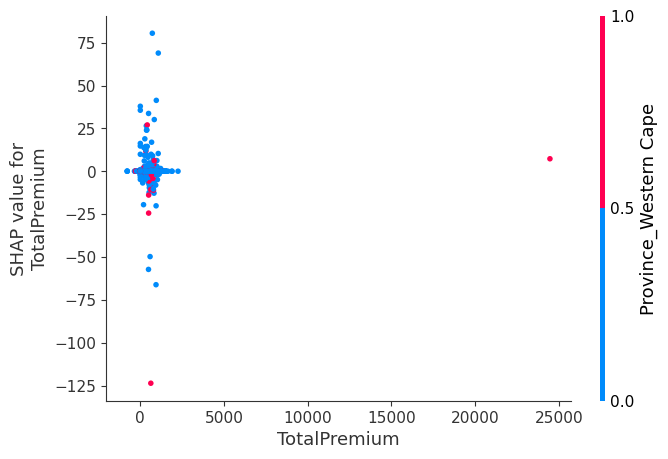

In [16]:
# Visualize how a specific feature affects predictions
shap.dependence_plot("TotalPremium", shap_values, X_test)

In [17]:
# Visualize individual predictions
shap.initjs()  # Initialize the JS visualization in the notebook

# Select an observation to explain (e.g., the first observation in X_test)
observation_index = 2
shap.force_plot(explainer.expected_value, shap_values[observation_index], X_test.iloc[observation_index])

In [20]:
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer

# Step 1: Standardize the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Initialize LIME with the scaled data
lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled,  # Use scaled training data
    feature_names=X_train.columns.tolist(),  # Feature names from training data
    mode='regression'  # Set mode to 'regression' for RandomForestRegressor
)

# Step 3: Select and preprocess the observation (use scaled data)
observation_index = 4
data_row = X_test_scaled[observation_index].reshape(1, -1)  # Reshape to 2D

# Step 4: Test the model's prediction on the selected row
prediction = baseline_model.predict(data_row)
print("Prediction for the observation:", prediction)

# Step 5: Generate the explanation for the observation
lime_exp = lime_explainer.explain_instance(
    data_row=data_row.flatten(),  # Flatten the row if required
    predict_fn=baseline_model.predict
)

# Visualize the explanation
lime_exp.show_in_notebook()



c:\Users\hp\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Prediction for the observation: [0.]


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.

In [48]:
# Test the model's predict function on the selected observation
prediction = baseline_model.predict(data_row)
print("Prediction for the observation:", prediction)


Prediction for the observation: [0.]


c:\Users\hp\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
